In [15]:
import apogee.tools.read as apread
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [16]:
import apogee.spec

In [17]:
data = apread.rcsample()

In [18]:
def get_spectra(data):
    """
    Returns spectra and header information for each object specified in data
    
    data:    labels for a subset of the APOGEE survey
    """
    specs = []
    errs = []
    hdrs = []
    for i in range(len(data)):
        spec,hdr = apread.aspcapStar(data['LOCATION_ID'][i],data['APOGEE_ID'][i],aspcapWavegrid=True)
        specs.append(spec)
        hdrs.append(hdr)
        err,hdr = apread.aspcapStar(data['LOCATION_ID'][i],data['APOGEE_ID'][i],ext=2,aspcapWavegrid=True)
        errs.append(err)
    return np.array(specs),np.array(errs),hdrs

def makematrix(x,order):
    if isinstance(x,tuple):
        nindeps = len(x)
        X = np.empty((len(x[0]),order*nindeps+1))
        X[:,0] = x[0]**0
        i = 1
        while i < order*nindeps+1:
            for o in range(1,order+1):
                for n in range(nindeps):
                    X[:,i] = x[n]**o
                    i+=1
    elif isinstance(x,(list,np.ndarray)):
        X = np.empty((len(x),order+1))
        for o in range(order+1):
            X[:,o] = x**o
    X = np.matrix(X)
    return X

def regfit(x,y,order = 1):
    """
    Fits a (nD-)polynomial of specified order with independent values given in x,
    given dependent values in y.
    
    x:       array of independent variable 
            (may be tuple containing arrays of multiple variables)   
    y:       array of dependent variable (must have same shape as array in x)
    order:   order of polynomial to fit (kwarg, default = 1)
    
    Returns the polynomial coefficents ascending from 0th order. In the case of
    multiple independent variables, returns coefficients at each polynomial order
    in order of the variables listed in x.
    """
    X = makematrix(x,order)
    return np.array(np.linalg.inv(X.T*X)*X.T*np.matrix(y).T)

def regerr(x,y,xerr,yerr,order=1):
    X = makematrix(x,order)
    Xerr = makematrix(xerr,order)
    

def poly(p,x,order = 1):
    """
    For a given set of polynomial coefficients ascending from
    0th order, and a independent variables, returns polynomial.
    """
    if isinstance(x,tuple):
        nindeps = len(x)
        order = (len(p)-1)/nindeps
        y = np.zeros(x[0].shape)
        y += p[0]*x[0]**0
        i = 1
        while i < order*nindeps+1:
            for o in range(1,order+1):
                for n in range(nindeps):
                    y+=p[i]*x[n]**o
                    i+=1
    elif isinstance(x,(list,np.ndarray)):
        order = len(p)-1
        y = np.zeros(x.shape)
        o = 0
        while o <= order:
            y += p[o]*x**o
            o += 1
    return y
        

In [19]:
# Basic function testing
x = np.arange(2,5,0.01)
c = np.log(np.copy(x))
y = np.copy(x)**3+c**2+9
ptest = regfit((x,c),y,order = 3)

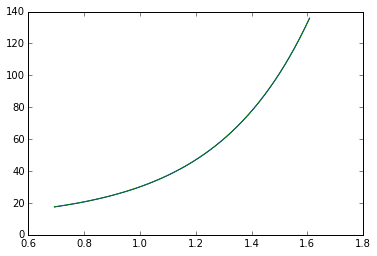

In [20]:
# Basic function testing
plt.plot(c,y)
plt.plot(c,poly(ptest,(x,c),order = 3))

In [21]:
def slice_data(data,sliceinfo):
    label, lower, upper = sliceinfo
    indx = (data[label]>lower) & (data[label]<upper)
    data = data[indx]
    return data

In [38]:
pix = 6296
data = slice_data(data,['METALS',0.45,0.5])
specs,errs,hdrs = get_spectra(data)
p = regfit((data['TEFF'],data['LOGG'],data['METALS']),specs[:,pix],order = 1)
p

array([[ -1.97492900e-01],
       [  1.62524806e-04],
       [ -2.00338690e-02],
       [  9.97483039e-02]])

In [39]:
Teff = np.arange(min(data['TEFF']),max(data['TEFF']))
logg = np.arange(min(data['LOGG']),max(data['LOGG']),((max(data['LOGG']-min(data['LOGG'])))/len(Teff)))
metals = np.arange(min(data['METALS']),max(data['METALS']),((max(data['METALS']-min(data['METALS'])))/len(Teff)))
len(logg)
pl = np.where(errs[:,pix] < 0.5)
rpl = np.where(errs[:,pix] > 0.5)

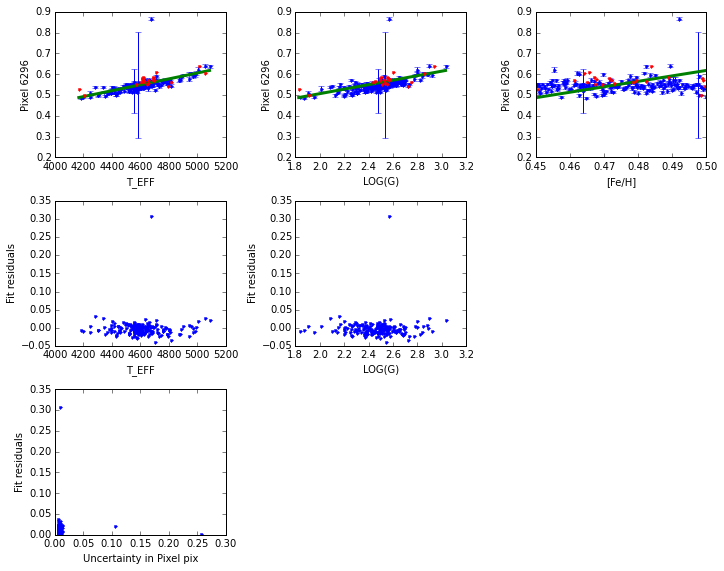

In [40]:
plt.figure(figsize = (10,8))
plt.subplot2grid((3,3),(0,0))
plt.errorbar(data['TEFF'][pl],specs[:,pix][pl],yerr = errs[:,pix][pl],fmt='.')
plt.plot(Teff,poly(p,(Teff,logg,metals)),linewidth = 3)
plt.plot(data['TEFF'][rpl],specs[:,pix][rpl],'.')
plt.xlabel('T_EFF')
plt.ylabel('Pixel {0}'.format(pix))
plt.subplot2grid((3,3),(1,0))
plt.plot(data['TEFF'][pl],specs[:,pix][pl] - poly(p,(data['TEFF'][pl],data['LOGG'][pl],data['METALS'][pl])),'.')
plt.xlabel('T_EFF')
plt.ylabel('Fit residuals')
plt.subplot2grid((3,3),(2,0))
plt.plot(errs[:,pix][pl],abs(specs[:,pix][pl] - poly(p,(data['TEFF'][pl],data['LOGG'][pl],data['METALS'][pl]))),'.')
plt.xlabel('Uncertainty in Pixel pix')
plt.ylabel('Fit residuals')
plt.subplot2grid((3,3),(0,1))
plt.errorbar(data['LOGG'][pl],specs[:,pix][pl],yerr = errs[:,pix][pl],fmt='.')
plt.plot(logg,poly(p,(Teff,logg,metals)),linewidth = 3)
plt.plot(data['LOGG'][rpl],specs[:,pix][rpl],'.')
plt.xlabel('LOG(G)')
plt.ylabel('Pixel {0}'.format(pix))
plt.subplot2grid((3,3),(1,1))
plt.plot(data['LOGG'][pl],specs[:,pix][pl] - poly(p,(data['TEFF'][pl],data['LOGG'][pl],data['METALS'][pl])),'.')
plt.xlabel('LOG(G)')
plt.ylabel('Fit residuals')
plt.tight_layout()
plt.subplot2grid((3,3),(0,2))
plt.errorbar(data['METALS'][pl],specs[:,pix][pl],yerr = errs[:,pix][pl],fmt='.')
plt.plot(metals,poly(p,(Teff,logg,metals)),linewidth = 3)
plt.plot(data['METALS'][rpl],specs[:,pix][rpl],'.')
plt.xlabel('[Fe/H]')
plt.ylabel('Pixel {0}'.format(pix))
plt.subplot2grid((3,3),(1,2))
plt.plot(data['TEFF'][pl],specs[:,pix][pl] - poly(p,(data['TEFF'][pl],data['LOGG'][pl],data['METALS'][pl])),'.')
plt.xlabel('T_EFF')
plt.ylabel('Fit residuals')

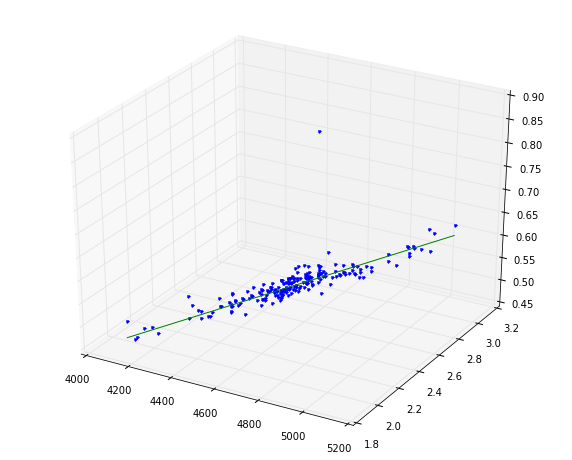

In [25]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(data['TEFF'],data['LOGG'],specs[:,6296],'.')
ax.plot(Teff,logg,poly(p,(Teff,logg)))


XTENSION= 'IMAGE   '           / IMAGE extension
BITPIX  =                  -32 / Number of bits per data pixel
NAXIS   =                    1 / Number of data axes
NAXIS1  =                 8575 /
PCOUNT  =                    0 / No Group Parameters
GCOUNT  =                    1 / One Data Group
CRVAL1  =        4.17900000000 /
CDELT1  =    6.00000000000E-06 /
CRPIX1  =                    1 /
CTYPE1  = 'LOG-LINEAR'         /
DC-FLAG =                    1 /